Using a dataset of your choice, select an outcome variable and then pick four or five other variables (one to two categorical, three to four continuous) to act as the basis for features. Explore the variables using the univariate and bivariate methods you've learned so far. 

Next, based on what you learned via your data exploration, create ten new features. Explain the reasoning behind each one.

Finally, use filtering methods to select the five best features and justify your choices.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import ttest_1samp
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
import csv, sqlite3
%matplotlib inline

from GDELT_utils import GDELT_columns, usecols, dtype_dict, \
                        cameo_dict, map_cameo_to_text, \
                        state_dict, mem_usage, state_heat_map

In [3]:
con = sqlite3.connect("gdelt.db")

In [4]:
gdelt = pd.read_sql_query("SELECT SQLDATE, Actor1CountryCode, Actor2CountryCode, \
                            Actor1Geo_CountryCode, Actor2Geo_CountryCode, \
                            EventRootCode, AVG(NumMentions), AVG(AvgTone) \
                          FROM gdelt \
                          WHERE SQLDATE > \"2017-05-01\" AND SQLDATE < \"2017-08-01\" \
                          GROUP BY SQLDATE, Actor1CountryCode, Actor2CountryCode, \
                          Actor1Geo_CountryCode, Actor2Geo_CountryCode, EventRootCode", con)
# aggregate data by
# Date Actor1Code Actor2Code Actor1Geo_CountryCode Actor2Geo_CountryCode EventRootCode -> Mean AvgTone

# Features Actor1Code Actor2Code Actor1Geo_CountryCode Actor2Geo_CountryCode NumMentions EventRootCode 

In [5]:
interest = ["SQLDATE",
            "AvgTone", "NumMentions", "EventRootCode",
            "Actor1CountryCode", "Actor2CountryCode",
            "Actor1Geo_CountryCode", "Actor2Geo_CountryCode"]

categories = ["EventRootCode",
            "Actor1CountryCode", "Actor2CountryCode",
            "Actor1Geo_CountryCode", "Actor2Geo_CountryCode"]

for category_col in categories:
    gdelt[category_col] = gdelt[category_col].astype('category')
    
gdelt['SQLDATE'] = pd.to_datetime(gdelt['SQLDATE'])  

In [6]:
gdelt = gdelt.drop(labels=gdelt[(gdelt['EventRootCode'] == "--")].index)

In [7]:
gdelt.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4370484 entries, 0 to 4370490
Data columns (total 8 columns):
SQLDATE                  datetime64[ns]
Actor1CountryCode        category
Actor2CountryCode        category
Actor1Geo_CountryCode    category
Actor2Geo_CountryCode    category
EventRootCode            category
AVG(NumMentions)         float64
AVG(AvgTone)             float64
dtypes: category(5), datetime64[ns](1), float64(2)
memory usage: 171.0 MB


In [8]:
gdelt_sample = gdelt.sample(frac=.05)

In [8]:
gdelt_tones = gdelt_sample['AVG(AvgTone)']

In [9]:
gdelt_tones

3116627    -5.581395
248721      1.073353
2377850     0.000000
2318693    -1.948718
3116385    -1.389262
1045567     2.595797
437602     -4.761905
3070938     1.629328
2836150    -1.948553
28496       0.123468
203264     -4.050633
421380      2.978723
4225428    -7.567567
3883297    -1.694915
3852277    -1.952702
1417852     1.556420
3607115     0.823045
2789027    -6.910569
2190439    -0.048417
846320     -0.891253
2078575    -2.180685
863276      0.000000
3055385    -5.755396
2291302    -8.392435
2949460    -2.960526
1010147    -1.059002
4281787     0.675327
2253370    -0.505050
4348408   -20.306513
24907      -3.311793
             ...    
1932943    -5.536332
3203921     6.756976
2970021    -5.701755
190966     -0.237626
3669949    -1.011152
2841907    -2.348993
1463856    -2.921348
3245074    -2.007911
2346595    -4.609195
2686539    -4.489796
410047      1.824066
4078607     0.694444
3328591    -0.804829
4223609     1.342282
1635676     3.015075
1345661     7.725322
1258852    -5

In [10]:
gdelt_cntry = gdelt_sample['Actor1CountryCode']

In [11]:
gdelt_cntry

3116627    EUR
248721     PNG
2377850    EGY
2318693    RUS
3116385    EUR
1045567    GBR
437602     NaN
3070938    GBR
2836150    NaN
28496      JPN
203264     TJK
421380     NZL
4225428    CUB
3883297    RUS
3852277    NaN
1417852    RUS
3607115    AUT
2789027    NaN
2190439    CAN
846320     AFR
2078575    NaN
863276     ISR
3055385    NaN
2291302    NaN
2949460    CHL
1010147    SEA
4281787    SAS
2253370    GBR
4348408    IND
24907      GTM
          ... 
1932943    SYC
3203921    NaN
2970021    RUS
190966     ITA
3669949    USA
2841907    NaN
1463856    MAR
3245074    TGO
2346595    GBR
2686539    IRN
410047     GBR
4078607    DEU
3328591    FRA
4223609    CHE
1635676    SWE
1345661    NaN
1258852    NaN
3951261    NaN
3184606    QAT
2833043    NaN
820989     THA
668659     NaN
258323     USA
568663     FJI
3942764    ZWE
3047739    NaN
2640628    GBR
3583527    SYR
2939283    NaN
1935041    TUR
Name: Actor1CountryCode, Length: 874097, dtype: category
Categories (221, object): [A

In [12]:
Actor1CC_one_hot = pd.get_dummies(gdelt_cntry, 
                                  prefix="Actor1CountryCode")
Actor1CC_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 874097 entries, 3116627 to 1935041
Columns: 221 entries, Actor1CountryCode_ABW to Actor1CountryCode_ZWE
dtypes: uint8(221)
memory usage: 230.9 MB


In [13]:
Actor1CC_one_hot = pd.get_dummies(gdelt_cntry)
Actor1CC_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 874097 entries, 3116627 to 1935041
Columns: 221 entries, ABW to ZWE
dtypes: uint8(221)
memory usage: 230.9 MB


In [138]:
# other direction didn't work??? non-categorical error
Actor1CC_one_hot = pd.get_dummies(gdelt_cntry)
Actor1CC_one_hot.info()

Actor1CC_tone = pd.concat([gdelt_tones, Actor1CC_one_hot], axis=1)

In [140]:
column = Actor1CC_one_hot.columns[0]
temp = Actor1CC_tone[[column, 'AVG(AvgTone)']]
temp.groupby(column).mean()['AVG(AvgTone)']
country = temp[temp[column] == 1]
country

,ABW,AVG(AvgTone)
1606835,1,5.574913
3211172,1,-4.397163
641015,1,1.569616
2293363,1,1.670644
2131593,1,0.874636
2991288,1,-0.205339
2293358,1,-1.632653
1726538,1,6.854839
3501167,1,4.928458
3714140,1,-5.949008


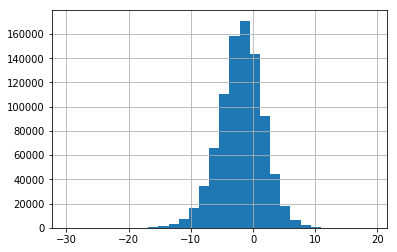

In [142]:
# CLT applies here right?
Actor1CC_tone['AVG(AvgTone)'].hist(bins=30)

In [143]:
len(Actor1CC_tone)

874097

In [40]:
avg_avgtone_mean = Actor1CC_tone['AVG(AvgTone)'].mean()
avg_avgtone_std = Actor1CC_tone['AVG(AvgTone)'].std()

In [41]:
# country_AVG(AvgTone)_mean - AVG(AvgTone).mean() / AVG(AvgTone).std()

In [144]:
country_tones = []
country_info = []
for column in Actor1CC_one_hot.columns:
    temp = Actor1CC_tone[[column, 'AVG(AvgTone)']]
    country = temp[temp[column] == 1]
    if len(country) < 10:
        print(country)
        continue
    column_means = temp.groupby(column).mean()['AVG(AvgTone)']
    country_tones.append(column_means)
    country_info.append((column, column_means[0] - column_means[1], np.absolute(column_means[0] - column_means[1]), 
                        (temp[column].sum()), ttest_1samp(country, avg_avgtone_mean).pvalue[1]))

         CAU  AVG(AvgTone)
4075937    1           5.0
        LAM  AVG(AvgTone)
470528    1      5.882353
         PRI  AVG(AvgTone)
2816124    1      -2.34375
Empty DataFrame
Columns: [ROM, AVG(AvgTone)]
Index: []
        SAM  AVG(AvgTone)
624264    1     -7.782101
         SCN  AVG(AvgTone)
2268886    1      3.174603
2319715    1      1.379310
2771568    1      0.572344
Empty DataFrame
Columns: [WLF, AVG(AvgTone)]
Index: []


In [145]:
country_info

[('ABW', -2.195036679236486, 2.195036679236486, 67, 9.90486546626223e-06),
 ('AFG',
  1.4017077162610487,
  1.4017077162610487,
  6110,
  1.9996841316352543e-209),
 ('AFR',
  -1.0218868005710244,
  1.0218868005710244,
  9999,
  1.2816953148046793e-173),
 ('AGO', -1.0928342841442864, 1.0928342841442864, 708, 6.265882819216623e-14),
 ('AIA', -3.472197449833909, 3.472197449833909, 52, 4.127738969385745e-09),
 ('ALB', -0.2626279698597731, 0.2626279698597731, 757, 0.028642316592579212),
 ('AND', -1.067507103024583, 1.067507103024583, 18, 0.07450773699401492),
 ('ARE',
  -0.4027557954683554,
  0.4027557954683554,
  4655,
  2.3614518543478937e-13),
 ('ARG', -0.6443935711713313, 0.6443935711713313, 1672, 7.480523283132169e-13),
 ('ARM', -0.9466522618627278, 0.9466522618627278, 2137, 2.686405841829021e-28),
 ('ASA', -2.78698745515422, 2.78698745515422, 176, 1.1754708172996876e-30),
 ('ATG', -1.71443330590783, 1.71443330590783, 211, 1.9862511973015026e-09),
 ('AUS',
  -0.7248767551783097,
  0.72

In [146]:
cntry_spec = pd.DataFrame(country_info, columns=["Country", "AvgTone_diff", "AvgTone_mag", "Num", "p-value"])

In [ ]:
gdelt_tones = gdelt_sample['AVG(AvgTone)']
gdelt_cntry = gdelt_sample['Actor1CountryCode']
print("1")
Actor1CC_one_hot = pd.get_dummies(gdelt_cntry)
Actor1CC_one_hot.info()

Actor1CC_tone = pd.concat([gdelt_tones, Actor1CC_one_hot], axis=1)
print("2")
avg_avgtone_mean = Actor1CC_tone['AVG(AvgTone)'].mean()
avg_avgtone_std = Actor1CC_tone['AVG(AvgTone)'].std()

country_tones = []
country_info = []
for column in Actor1CC_one_hot.columns:
    temp = Actor1CC_tone[[column, 'AVG(AvgTone)']]
    country = temp[temp[column] == 1]
    if len(country) < 10:
        print(country)
        continue
    column_means = temp.groupby(column).mean()['AVG(AvgTone)']
    country_tones.append(column_means)
    country_info.append((column, column_means[0] - column_means[1], np.absolute(column_means[0] - column_means[1]), 
                        (temp[column].sum()), ttest_1samp(country, avg_avgtone_mean).pvalue[1]))
print("3")
cntry_spec = pd.DataFrame(country_info, columns=["Country", "AvgTone_diff", "AvgTone_mag", "Num", "p-value"])

low_decs_A1CC = cntry_spec[((cntry_spec['p-value'] > 0.0001) & ((cntry_spec['AvgTone_mag'] < 1) & \
           (cntry_spec['AvgTone_diff'] < 0)))]['Country']

low_incs_A1CC = cntry_spec[((cntry_spec['p-value'] > 0.0001) & ((cntry_spec['AvgTone_mag'] < 1) & \
           (cntry_spec['AvgTone_diff'] > 0)))]['Country']

low_p_value_A1CC = cntry_spec[((cntry_spec['p-value'] > 0.0001) & ~((cntry_spec['AvgTone_mag'] < 1) & \
           (cntry_spec['AvgTone_diff'] < 0)) & ~((cntry_spec['AvgTone_mag'] < 1) & \
           (cntry_spec['AvgTone_diff'] > 0)))]

In [18]:
gdelt_tones = gdelt_sample['AVG(AvgTone)']
def dim_reduce(column):
    gdelt_cntry = gdelt_sample[column]

    one_hot = pd.get_dummies(gdelt_cntry)
    
    one_hot_tone = pd.concat([gdelt_tones, one_hot], axis=1)

    avg_avgtone_mean = one_hot_tone['AVG(AvgTone)'].mean()
    avg_avgtone_std = one_hot_tone['AVG(AvgTone)'].std()

    country_tones = []
    country_info = []
    for column in one_hot.columns:
        temp = one_hot_tone[[column, 'AVG(AvgTone)']]
        country = temp[temp[column] == 1]
        if len(country) < 10:
            #print(country)
            continue
        column_means = temp.groupby(column).mean()['AVG(AvgTone)']
        country_tones.append(column_means)
        country_info.append((column, column_means[0] - column_means[1], np.absolute(column_means[0] - column_means[1]), 
                            (temp[column].sum()), ttest_1samp(country, avg_avgtone_mean).pvalue[1]))

    cntry_spec = pd.DataFrame(country_info, columns=["Country", "AvgTone_diff", "AvgTone_mag", "Num", "p-value"])

    low_decs = cntry_spec[((cntry_spec['p-value'] > 0.0001) & ((cntry_spec['AvgTone_mag'] < 1) & \
               (cntry_spec['AvgTone_diff'] < 0)))]['Country']

    low_incs = cntry_spec[((cntry_spec['p-value'] > 0.0001) & ((cntry_spec['AvgTone_mag'] < 1) & \
               (cntry_spec['AvgTone_diff'] > 0)))]['Country']

    low_p_value = cntry_spec[((cntry_spec['p-value'] > 0.0001) & ~((cntry_spec['AvgTone_mag'] < 1) & \
               (cntry_spec['AvgTone_diff'] < 0)) & ~((cntry_spec['AvgTone_mag'] < 1) & \
               (cntry_spec['AvgTone_diff'] > 0)))]['Country']
    
    return low_decs, low_incs, low_p_value

In [16]:
gdelt_sample['Actor1CountryCode'].unique()

[BLR, CZE, USA, NaN, GBR, ..., EAF, SAM, SCN, SHN, CAU]
Length: 219
Categories (218, object): [BLR, CZE, USA, GBR, ..., SAM, SCN, SHN, CAU]

In [24]:
low_decs_A1CC, low_incs_A1CC, low_p_value_A1CC = dim_reduce('Actor1CountryCode')
low_decs_A2CC, low_incs_A2CC, low_p_value_A2CC = dim_reduce('Actor2CountryCode')
low_decs_A1GCC, low_incs_A1GCC, low_p_value_A1GCC = dim_reduce('Actor1Geo_CountryCode')
low_decs_A2GCC, low_incs_A2GCC, low_p_value_A2GCC = dim_reduce('Actor2Geo_CountryCode')

In [44]:
model_df = gdelt_sample.copy()

In [45]:
def map_missing(x, low_decs, low_incs, low_p_value, translation):
    #if x in l:
    #    return x
    if x == "nan":
        return "UNKNOWN"
    elif x in low_decs:
        return "LOW_DEC"
    elif x in low_incs:
        return "LOW_INCS"
    elif x in low_p_value:
        return "LOW_P_VALUE"
    else:
        return x

def unify_cats(data, category, low_decs, low_incs, low_p_value):
    low_decs_unique = low_decs.unique()
    low_decs_unique = low_incs.unique()
    low_p_value_unique = low_p_value.unique()
    data[(category + '_unify')] = data[category].astype(str) \
                                                .apply(lambda x: map_missing(x, low_decs_unique, 
                                                                             low_decs_unique, 
                                                                             low_p_value_unique, 
                                                                             "OTHER")) \
                                                .astype('category')

In [46]:
unify_cats(model_df, 'Actor1CountryCode', low_decs_A1CC, low_incs_A1CC, low_p_value_A1CC)
unify_cats(model_df, 'Actor2CountryCode', low_decs_A2CC, low_incs_A2CC, low_p_value_A2CC)
unify_cats(model_df, 'Actor1Geo_CountryCode', low_decs_A1GCC, low_incs_A1GCC, low_p_value_A1GCC)
unify_cats(model_df, 'Actor2Geo_CountryCode', low_decs_A2GCC, low_incs_A2GCC, low_p_value_A2GCC)

In [47]:
model_df['Actor1CountryCode_unify'].value_counts()

UNKNOWN        63526
USA            19294
LOW_DEC         7356
GBR             6861
CHN             5742
RUS             5508
FRA             4011
EUR             3884
DEU             3844
ISR             3088
SAU             3064
AUS             3053
TUR             2861
CAN             2807
IRN             2779
SYR             2456
AFR             2439
JPN             2355
PAK             2150
ITA             2121
QAT             1995
EGY             1919
PRK             1775
PHL             1680
IND             1650
LOW_P_VALUE     1598
KOR             1569
AFG             1533
IRQ             1529
NGA             1502
               ...  
LCA              101
LSO               92
CYM               87
WSM               84
VCT               78
KNA               76
PRY               67
ATG               59
SYC               51
ASA               45
VUT               44
TON               42
TMP               39
COK               36
NRU               32
HKG               32
GAB          

In [48]:
model_df['norm_NumMentions'] = (model_df['AVG(NumMentions)'] - model_df['AVG(NumMentions)'].mean())/ \
                                        model_df['AVG(NumMentions)'].std()

In [61]:
#model_df = model_df.drop(['Actor1CountryCode', 'Actor2CountryCode', 'Actor1Geo_CountryCode', 
#               'Actor2Geo_CountryCode', 'AVG(NumMentions)', 'SQLDATE'], axis=1)

Actor1CC_one_hot = pd.get_dummies(model_df['Actor1CountryCode_unify'], prefix="Actor1CountryCode")
Actor2CC_one_hot = pd.get_dummies(model_df['Actor2CountryCode_unify'], prefix="Actor2CountryCode")
Actor1CCGeo_one_hot = pd.get_dummies(model_df['Actor1Geo_CountryCode_unify'], prefix="Actor1Geo_CountryCode")
Actor2CCGeo_one_hot = pd.get_dummies(model_df['Actor2Geo_CountryCode_unify'], prefix="Actor2Geo_CountryCode")
EventRoot_one_hot = pd.get_dummies(model_df['EventRootCode'], prefix="EventRootCode")

one_hot_encoding = pd.concat([Actor1CC_one_hot, Actor2CC_one_hot, Actor1CCGeo_one_hot, 
                              Actor2CCGeo_one_hot, EventRoot_one_hot], axis=1)

model_df_hot = pd.concat([model_df, one_hot_encoding], axis=1).drop(['Actor1CountryCode_unify',
                                                                    'Actor2CountryCode_unify',
                                                                    'Actor1Geo_CountryCode_unify',
                                                                    'Actor2Geo_CountryCode_unify'], axis=1)

In [66]:
feature_columns = model_df_hot.drop(['AVG(AvgTone)'], axis=1).columns

In [67]:
feature_columns

Index(['EventRootCode', 'norm_NumMentions', 'Actor1CountryCode_AFG',
       'Actor1CountryCode_AFR', 'Actor1CountryCode_AGO',
       'Actor1CountryCode_AND', 'Actor1CountryCode_ARE',
       'Actor1CountryCode_ARG', 'Actor1CountryCode_ARM',
       'Actor1CountryCode_ASA',
       ...
       'EventRootCode_11', 'EventRootCode_12', 'EventRootCode_13',
       'EventRootCode_14', 'EventRootCode_15', 'EventRootCode_16',
       'EventRootCode_17', 'EventRootCode_18', 'EventRootCode_19',
       'EventRootCode_20'],
      dtype='object', length=760)

In [63]:
model_df_hot.head()

,EventRootCode,AVG(AvgTone),norm_NumMentions,Actor1CountryCode_AFG,Actor1CountryCode_AFR,Actor1CountryCode_AGO,Actor1CountryCode_AND,Actor1CountryCode_ARE,Actor1CountryCode_ARG,Actor1CountryCode_ARM,...,EventRootCode_11,EventRootCode_12,EventRootCode_13,EventRootCode_14,EventRootCode_15,EventRootCode_16,EventRootCode_17,EventRootCode_18,EventRootCode_19,EventRootCode_20
4074733,05,-1.863354,-0.185329,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2951801,11,-4.629902,-0.185329,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2498415,04,-6.752873,-0.214884,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4368703,13,-3.281616,0.030843,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2508227,10,-3.082279,0.051109,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
train, test = train_test_split(model_df_hot, test_size=0.2, random_state=42)

In [68]:
regr = linear_model.LinearRegression()
Y = train['AVG(AvgTone)'].values.reshape(-1, 1)
X = train[feature_columns]
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [69]:
regr.score(X, Y)

0.24057144216501747

In [72]:
from sklearn.linear_model import Ridge
regr = Ridge()
Y = train['AVG(AvgTone)'].values.reshape(-1, 1)
X = train[feature_columns]
regr.fit(X, Y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [73]:
regr.score(X, Y)

0.24050873555027785

In [76]:
regr.coef_

array([[-1.92154681e-01, -8.64475465e-02, -7.31530799e-01,
         5.61747574e-01, -2.73420486e-01,  7.81067133e-01,
         2.03108040e-01, -1.10895946e-01,  3.06508877e-01,
         1.61308183e+00,  7.33502665e-02, -1.03023577e-01,
        -1.33068718e-01,  1.71900143e-02, -3.44253170e-01,
         2.25942862e-01,  2.79051428e-01, -5.96752570e-01,
        -1.25006821e-02,  5.36076310e-01,  3.35896326e-01,
         3.55521060e-01, -3.10577008e-01,  4.62512750e-02,
        -2.01461457e-01,  1.72967772e-01, -6.72760136e-01,
        -5.30364259e-02, -1.44969082e+00,  7.16590656e-02,
        -2.19592022e+00,  2.74398012e+00,  2.42498482e-01,
         5.04102196e-01,  1.82456465e-02, -1.12354870e-01,
        -7.82562321e-01, -1.42323253e+00, -1.43921719e+00,
         9.13817242e-01,  2.59792482e+00, -1.37532762e-01,
         2.33088351e-01, -7.36902120e-01,  3.92990112e-01,
        -2.10608974e-02, -3.02212839e-01, -3.33801057e-01,
         3.20327253e-01, -7.27623002e-02, -5.65460991e-0

In [ ]:
def compute_RSS(model, data, dependent):
    predictions = model.predict(data)
    squared_residuals = (dependent.values.reshape(-1, 1) - predictions) ** 2
    return squared_residuals.sum()

def compute_TSS(data, dependent):
    return ((dependent.values.reshape(-1, 1) - dependent.values.reshape(-1, 1).mean()) ** 2).sum()

def F_statistic(p, data, model):
    n = len(data)
    RSS = compute_RSS(model, data)
    TSS = compute_TSS(data)
    return ((TSS - RSS) / p) /\
            (RSS / (n - p - 1))

In [80]:
#1 - compute_RSS(regr, train[feature_columns], train['norm_AvgTone'])/ \
#    compute_TSS(train[feature_columns], train['norm_AvgTone'])

baseline = 1 - ((model_df['AVG(AvgTone)'] - model_df['AVG(AvgTone)'].mean())**2).sum() /\
            ((model_df['AVG(AvgTone)'] - model_df['AVG(AvgTone)'].mean()) ** 2).sum()

In [81]:
baseline

0.0

In [179]:
len(low_p_value) + len(low_incs) + len(low_decs)

61

In [ ]:
#  	Country 	AvgTone_diff 	AvgTone_mag 	Num 	p-value
# 200 	Actor1CountryCode_USA 	-0.057060 	0.057060 	76240 	1.288859e-05

In [186]:
def map_missing(x, l, translation):
    if x in l:
        return x
    elif x == "nan":
        return "UNKNOWN"
    else:
        return translation

def unify_rare_cats(data, category, cut_off):
    vc = data[category].value_counts()
    past_cut_off = (vc/len(data)) > cut_off
    remaining = list(vc[past_cut_off].index)
    data[(category + '_unify')] = data[category].astype(str) \
                                                .apply(lambda x: map_missing(x, remaining, "OTHER")) \
                                                .astype('category')

In [187]:
unify_rare_cats(gdelt_sample, 'Actor1CountryCode', .005)
unify_rare_cats(gdelt_sample, 'Actor2CountryCode', .005)
unify_rare_cats(gdelt_sample, 'Actor1Geo_CountryCode', .005)
unify_rare_cats(gdelt_sample, 'Actor2Geo_CountryCode', .005)

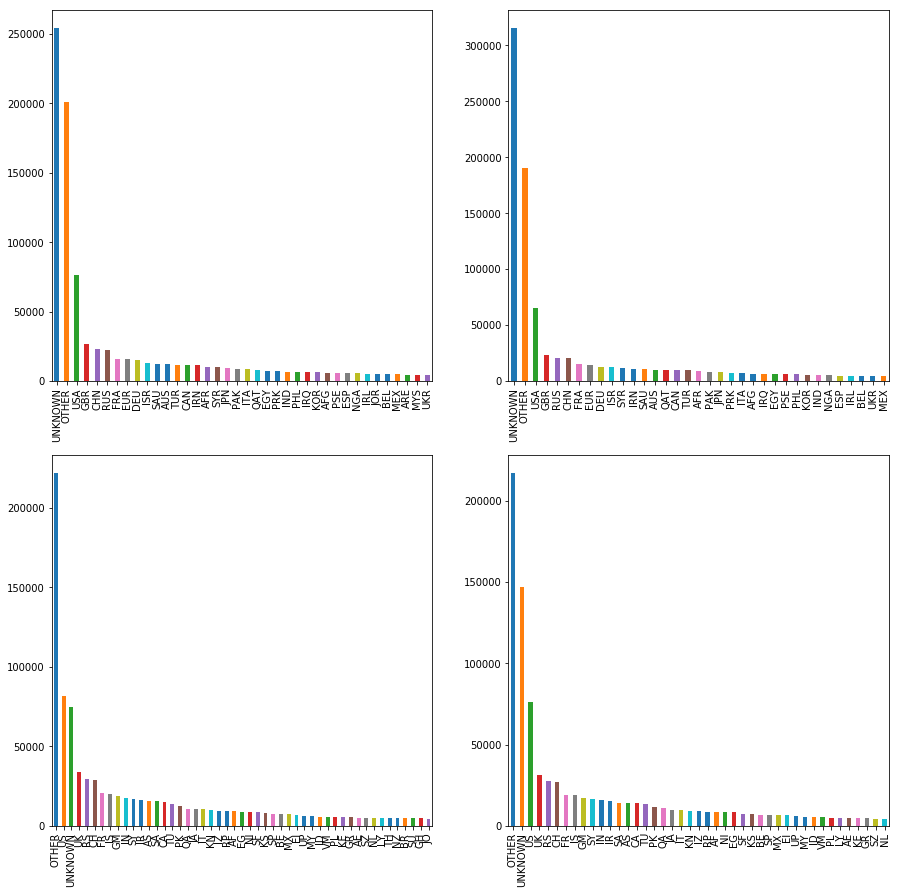

In [188]:
fig, axes = plt.subplots(2, 2, figsize=(15,15))

plt.subplot(221)
gdelt_sample['Actor1CountryCode_unify'].value_counts().plot(kind="bar")

plt.subplot(222)
gdelt_sample['Actor2CountryCode_unify'].value_counts().plot(kind="bar")

plt.subplot(223)
gdelt_sample['Actor1Geo_CountryCode_unify'].value_counts().plot(kind="bar")

plt.subplot(224)
gdelt_sample['Actor2Geo_CountryCode_unify'].value_counts().plot(kind="bar")

In [189]:
gdelt_sample['EventRootCode'].value_counts()

04    186354
01     94136
05     82198
03     71590
02     57839
11     55835
19     53003
17     42818
08     35904
07     33343
06     31310
12     25898
09     19476
13     19349
10     16293
18     16137
16     15156
14     10128
15      6741
20       589
--         0
Name: EventRootCode, dtype: int64

In [190]:
gdelt_sample['norm_NumMentions'] = (gdelt_sample['AVG(NumMentions)'] - gdelt_sample['AVG(NumMentions)'].mean())/ \
                                        gdelt_sample['AVG(NumMentions)'].std()

In [191]:
gdelt_sample['norm_AvgTone'] = (gdelt_sample['AVG(AvgTone)'] - gdelt_sample['AVG(AvgTone)'].mean())/ \
                                        gdelt_sample['AVG(AvgTone)'].std()

In [192]:
Actor1CC_one_hot = pd.get_dummies(gdelt_sample['Actor1CountryCode_unify'], prefix="Actor1CountryCode")
Actor2CC_one_hot = pd.get_dummies(gdelt_sample['Actor2CountryCode_unify'], prefix="Actor2CountryCode")
Actor1CCGeo_one_hot = pd.get_dummies(gdelt_sample['Actor1Geo_CountryCode_unify'], prefix="Actor1Geo_CountryCode")
Actor2CCGeo_one_hot = pd.get_dummies(gdelt_sample['Actor2Geo_CountryCode_unify'], prefix="Actor2Geo_CountryCode")
EventRoot_one_hot = pd.get_dummies(gdelt_sample['EventRootCode'], prefix="EventRootCode")

one_hot_encoding = pd.concat([Actor1CC_one_hot, Actor2CC_one_hot, Actor1CCGeo_one_hot, 
                              Actor2CCGeo_one_hot, EventRoot_one_hot], axis=1)

In [193]:
Actor1CC_one_hot = pd.get_dummies(gdelt_sample['Actor1CountryCode_unify'], prefix="Actor1CountryCode")
Actor2CC_one_hot = pd.get_dummies(gdelt_sample['Actor2CountryCode_unify'], prefix="Actor2CountryCode")
Actor1CCGeo_one_hot = pd.get_dummies(gdelt_sample['Actor1Geo_CountryCode_unify'], prefix="Actor1Geo_CountryCode")
Actor2CCGeo_one_hot = pd.get_dummies(gdelt_sample['Actor2Geo_CountryCode_unify'], prefix="Actor2Geo_CountryCode")
EventRoot_one_hot = pd.get_dummies(gdelt_sample['EventRootCode'], prefix="EventRootCode")

one_hot_encoding = pd.concat([Actor1CC_one_hot, Actor2CC_one_hot, Actor1CCGeo_one_hot, 
                              Actor2CCGeo_one_hot, EventRoot_one_hot], axis=1)

gdelt_sample = pd.concat([gdelt_sample, one_hot_encoding], axis=1)

In [194]:
model_columns = list(one_hot_encoding.columns)
model_columns.append('norm_NumMentions')
feature_columns = model_columns.copy()
model_columns.append('norm_AvgTone')

In [195]:
gdelt_sample_m = gdelt_sample[model_columns]

In [196]:
train, test = train_test_split(gdelt_sample_m, test_size=0.25, random_state=42)

In [197]:
regr = linear_model.LinearRegression()
Y = train['norm_AvgTone'].values.reshape(-1, 1)
X = train[feature_columns]
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [198]:
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[-4.47767839e+09 -4.47767839e+09 -4.47767839e+09 -4.47767839e+09
  -4.47767839e+09 -4.47767839e+09 -4.47767839e+09 -4.47767839e+09
  -4.47767839e+09 -4.47767839e+09 -4.47767839e+09 -4.47767839e+09
  -4.47767839e+09 -4.47767839e+09 -4.47767839e+09 -4.47767839e+09
  -4.47767839e+09 -4.47767839e+09 -4.47767839e+09 -4.47767839e+09
  -4.47767839e+09 -4.47767839e+09 -4.47767839e+09 -4.47767839e+09
  -4.47767839e+09 -4.47767839e+09 -4.47767839e+09 -4.47767839e+09
  -4.47767839e+09 -4.47767839e+09 -4.47767839e+09 -4.47767839e+09
  -4.47767839e+09 -4.47767839e+09 -4.47767839e+09 -4.47767839e+09
  -4.47767839e+09 -4.47767839e+09 -1.52421891e+11 -1.52421891e+11
  -1.52421891e+11 -1.52421891e+11 -1.52421891e+11 -1.52421891e+11
  -1.52421891e+11 -1.52421891e+11 -1.52421891e+11 -1.52421891e+11
  -1.52421891e+11 -1.52421891e+11 -1.52421891e+11 -1.52421891e+11
  -1.52421891e+11 -1.52421891e+11 -1.52421891e+11 -1.52421891e+11
  -1.52421891e+11 -1.52421891e+11 -1.52421891e+11 -1.524218

In [206]:
ransac = linear_model.RANSACRegressor(base_estimator=linear_model.LinearRegression())
Y = train['norm_AvgTone'].values.reshape(-1, 1)
X = train[feature_columns]
ransac.fit(X, Y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=None, random_state=None,
        residual_metric=None, residual_threshold=None, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

In [261]:
#print('\nCoefficients: \n', ransac.coef_)
#print('\nIntercept: \n', ransac.intercept_)
print('\nR-squared:')
print(ransac.score(X, Y))


R-squared:
-1.1878379205463898


In [207]:
Y.ravel()

array([ 0.41489874, -1.07088933, -0.32599356, ..., -0.4080762 ,
        0.46218327, -0.00540991])

In [209]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(max_depth=2, verbose=True)
Y = train['norm_AvgTone']
X = train[feature_columns]
gbr.fit(X, Y)

      Iter       Train Loss   Remaining Time 
         1           0.9874            1.83m
         2           0.9772            1.79m
         3           0.9660            1.92m
         4           0.9580            1.86m
         5           0.9508            1.82m
         6           0.9424            1.80m
         7           0.9363            1.76m
         8           0.9296            1.75m
         9           0.9234            1.73m
        10           0.9179            1.71m
        20           0.8822            1.50m
        30           0.8643            1.30m
        40           0.8529            1.11m
        50           0.8449           55.13s
        60           0.8386           43.88s
        70           0.8334           32.87s
        80           0.8292           21.80s
        90           0.8254           10.88s
       100           0.8220            0.00s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=True, warm_start=False)

In [210]:
gbr.score(X, Y)

0.17798947635006024

In [254]:
def compute_RSS(model, data, dependent):
    predictions = model.predict(data)
    squared_residuals = (dependent.values.reshape(-1, 1) - predictions) ** 2
    return squared_residuals.sum()

def compute_TSS(data, dependent):
    return ((dependent.values.reshape(-1, 1) - dependent.values.reshape(-1, 1).mean()) ** 2).sum()

def F_statistic(p, data, model):
    n = len(data)
    RSS = compute_RSS(model, data)
    TSS = compute_TSS(data)
    return ((TSS - RSS) / p) /\
            (RSS / (n - p - 1))

In [250]:
compute_RSS(regr, train[feature_columns], train['norm_AvgTone'])

516754.7841342668

In [251]:
compute_RSS(ransac, train[feature_columns], train['norm_AvgTone'])

1241031.7733438069

In [252]:
compute_RSS(regr, test[feature_columns], test['norm_AvgTone'])

172924.72077743677

In [253]:
compute_RSS(ransac, test[feature_columns], test['norm_AvgTone'])

414723.69992864854

In [257]:
1 - compute_RSS(regr, train[feature_columns], train['norm_AvgTone'])/ \
    compute_TSS(train[feature_columns], train['norm_AvgTone'])

0.21090464835551326

In [258]:
1 - compute_RSS(ransac, train[feature_columns], train['norm_AvgTone'])/ \
    compute_TSS(train[feature_columns], train['norm_AvgTone'])
    
# Well this is a weird outcome for R^2. Implies RSS is greater than TSS.

-0.8950814460853946

In [263]:
gdelt_sample['AvgTone_Pos?'] = gdelt_sample['norm_AvgTone'] > 0

In [275]:
class_model_columns = list(one_hot_encoding.columns)
class_model_columns.append('norm_NumMentions')
feature_columns = class_model_columns.copy()
class_model_columns.append('AvgTone_Pos?')

In [267]:
gdelt_sample_cm = gdelt_sample[class_model_columns]

In [271]:
class_train, class_test = train_test_split(gdelt_sample_cm, test_size=0.25, random_state=42)

In [277]:
bnb = BernoulliNB()
bnb.fit(class_train[feature_columns], class_train['AvgTone_Pos?'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [279]:
y_pred_train = bnb.predict(class_train[feature_columns])
error_rate = (class_train['AvgTone_Pos?'] != y_pred_train).sum()
print(error_rate/len(class_train))

0.3243213560066629


In [280]:
y_pred_test = bnb.predict(class_test[feature_columns])
error_rate = (class_test['AvgTone_Pos?'] != y_pred_test).sum()
print(error_rate/len(class_test))

0.32340464477748543
